# Remarks of the author

1. This code works as a skeleton, so that users can exploit it and define their own implementations. This means that the users should **NOT** expect to run solely this piece of code to get the figures of our paper https://doi.org/10.1109/GLOBECOM48099.2022.10001330. 

2. To specify the utility and cost functions, the users that are interested have 3 options:
    1. define their own functions/emulators, 
    2. use our (limited) dataset https://github.com/jaayala/power_dlul_dataset,
    3. send email to [m.kalntis@tudelft.nl](mailto:m.kalntis@tudelft.nl) for more information.

3. If you use any piece of the code here, please check *README.md* for citing.

# 1. Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# For reproducability
np.random.seed(5)

# 2. Functions to emulate testbed

In [2]:
class EmulationFunctions:
    """Class for utility, power cost, and reward calculation.
    
    Parameters
    ----------
    delta: float
        prioritizes utility or power cost function.
    """
    
    def __init__(self, delta: float) -> None:
        self.delta = delta

    def f_utility(self, s_t: tuple, cd_t: tuple) -> float:
        """Dummy utility function."""
        return sum(s_t) * np.random.random() + sum(cd_t) * np.random.random()

    def f_power(self, s_t: tuple, cd_t: tuple) -> float:
        """Dummy power cost function."""
        return sum(s_t) * np.random.random() + sum(cd_t) * np.random.random()

    def f_reward(self, s_t: tuple, cd_t: tuple) -> float:
        """Calculate the reward based on utility and power cost defined above."""
        utility = self.f_utility(s_t, cd_t)
        power = self.f_power(s_t, cd_t)
        return utility - self.delta * power

# 3. Configuration and Environment classes

In [3]:
class Configuration:
    """Class to define and handle system configurations.
    
    Parameters
    ----------
    p_dl: list
        maximum allowed vBS transmission power control in DL
    
    m_dl: list
        highest eligible MCS in DL
    
    m_ul: list
        maximum vBS transmission airtime in DL
    
    a_ul: list
        highest eligible MCS in UL
    
    m_ul: list
        maximum vBS transmission airtime in UL
    """

    def __init__(self, p_dl: list[float], m_dl: list[float], a_dl: list[float], m_ul: list[float], a_ul: list[float]) -> None:
        self.p_dl = p_dl
        self.m_dl = m_dl
        self.a_dl = a_dl
        self.m_ul = m_ul
        self.a_ul = a_ul

    def generate_configurations(self) -> list:
        """ Generate a dictionary with all possible combinations of the parameters"""
        return list(itertools.product(self.p_dl, self.m_dl, self.a_dl, self.m_ul, self.a_ul))

In [4]:
class Environment:
    """Class to generate the environment, i.e., channels conditions and traffic demands
    
    Parameters
    ----------
    c_dl: int
        Channel Quality Indicator (CQI) in DL
    
    c_ul: int
        CQI in UL
    
    d_dl: float
        traffic demands in DL
        
    d_ul: float
        traffic demands in UL
        
    T: int
        time horizon (total number of slots)
    """
    
    def __init__(self, c_dl: int, c_ul: int, d_dl: float, d_ul: float, T: int) -> None:
        self.c_dl = c_dl
        self.c_ul = c_ul
        self.d_dl = d_dl
        self.d_ul = d_ul
        self.T = T
    
    def generate_environment(self) -> list:
        return [(c_dl[t], c_ul[t], d_dl[t], d_ul[t]) for t in range(self.T)]
        

# 4. BSvBS algorithm

In [5]:
class BSvBSAlgorithm():
    """Class implementing the BSvBS algorithm
    
    Parameters
    ----------
    N: int
        number of times to run the simulation
    
    T: int
        time horizon (total number of slots)
        
    S: int
        number of configurations/arms
        
    delta: float
        prioritizes utility or power cost function.
    
    config_dict: dict
        dictionary, with key: number of arm (configuration) and 
        values (p_dl, m_dl, a_dl, a_ul, m_ul)
        
    cd_arr: list
        channel conditions and traffic demands
    
    reward_min: float, optional (default=-16)
        minimum reward value used to scale the rewards in [0, 1]
    
    reward_max: float, optional (default=-10)
        maximum reward value used to scale the rewards in [0, 1]
    """

    def __init__(self, N: int, T: int, S: int, delta: float, config_dict: dict[int, tuple], cd_arr: list, reward_min: float = -16, reward_max: float = -10) -> None:
        self.N = N
        self.T = T
        self.S = S
        self.delta = delta
        self.config_dict = config_dict
        self.cd_arr = cd_arr
        self.reward_min = reward_min
        self.reward_max = reward_max
        # used in the algorithm to balance exploration and exploitation
        self.gamma = min(1, np.sqrt(self.S * np.log(self.S) / ((np.exp(1) - 1) * self.T)))
        # reward/payoff of the selected arm/configuration chosen at every timestep
        self.reward_chosen = np.zeros((self.N, self.T)) 
        

    @staticmethod
    def draw_arm(probs: list[float]) -> int:
        """Draw arms/configurations from a multinomial distribution, based on the probabilities assigned to each arm."""
        arms = np.random.multinomial(1, probs)
        return np.nonzero(arms)[0][0]

    def run(self) -> tuple[np.ndarray, np.ndarray]:
        """Run BSvBS algorithm and return the reward of the chosen configurations and the environment at every timeslot"""
        emulation_func = EmulationFunctions(self.delta)
        for n in range(self.N):
            y = np.ones(self.S)
            for t in range(self.T):
                # update distribution
                score_sum = np.sum(y)
                logit_map = [(1.0 - self.gamma) * y_a / score_sum + self.gamma / self.S for y_a in y]
                x_t = logit_map
                # sample next configuration
                s_t_num = self.draw_arm(x_t)
                s_t = self.config_dict[s_t_num]
                # observe network conditions and user demands;
                # careful: these are not known in advance, even though the implentation here just reads them from cd_arr
                observe_cd = cd_arr[t]
                # receive and scale reward in [0, 1]
                reward = emulation_func.f_reward(s_t, observe_cd)
                reward = max(min(reward, reward_max), reward_min)
                reward_scaled = (reward - reward_min) / (reward_max - reward_min)
                # calculate weighted feedback
                u_estimate = np.zeros(self.S)
                u_estimate[s_t_num] = reward_scaled / x_t[s_t_num]
                # update the weights
                y[s_t_num] = y[s_t_num] * np.exp(u_estimate[s_t_num] * self.gamma / self.S)
                # save rewards
                self.reward_chosen[n, t] = reward_scaled

        return self.reward_chosen, self.cd_arr

# 5. Single best (ideal) configuration

**Important remarks:** 
* Due to the black-box approach considered in our work, BSvBS makes no assumption (e.g., convexity or closed-form expressions) for the utility and power cost functions; we just observe the utility of a configuration after we have tried it in our testbed (here, through the functions defined above in section 2). This ensures that our approach is applicable in cases that it is difficult to know the exact functions, or if these functions change arbitrarily. For that reason, we have to try all possible configurations to find which is the best performing one(s).
* We stress that finding the best configuration(s) is needed for the plots of regret, but it is not required when one uses our algorithm in practice. Calculating the single best configuration will take time, if a large number of timeslots and configurations are chosen, due to the quadratic complexity of trying them all, i.e., $\mathcal{O}(S T)$. 

In [6]:
class BestBenchmark():
    """Encapsulates the reward calculation process for all possible combinations of configurations
        
    Parameters
    ----------
    T: int
        time horizon (total number of slots)

    S: int
        number of configurations/arms

    delta: float
        prioritizes utility or power cost function.

    config_dict: dict
        dictionary, with key: number of arm (configuration) and 
        values (p_dl, m_dl, a_dl, a_ul, m_ul)

    cd_arr: list
        channel conditions and traffic demands

    reward_min: float, optional (default=-16)
        minimum reward value used to scale the rewards in [0, 1]

    reward_max: float, optional (default=-10)
        maximum reward value used to scale the rewards in [0, 1]
    """

    
    def __init__(self, T: int, S: int, delta: float, config_dict: dict[int, tuple], cd_arr: list, 
                 reward_min: float, reward_max: float) -> None:
        self.T = T
        self.S = S
        self.delta = delta
        self.config_dict = config_dict
        self.cd_arr = cd_arr
        self.reward_min = reward_min
        self.reward_max = reward_max
        self.reward_all = np.zeros((self.S, self.T))

    def calculate_best_benchmark(self) -> tuple[np.ndarray, np.ndarray]:
        """Calculate the rewards of all configurations and return their cumulative reward after each slot"""
        emulation_func = EmulationFunctions(self.delta)
        for t in range(self.T):
            for s in range(self.S):
                # try every configuration for every timeslot
                s_t = self.config_dict[s] 
                # receive and scale reward in [0, 1]
                reward = emulation_func.f_reward(s_t, self.cd_arr[t])
                reward_scaled = (reward - self.reward_min) / (self.reward_max - self.reward_min)
                # save the cumulative reward for every configuration until timeslot t
                self.reward_all[s][t] = reward_scaled if t == 0 else self.reward_all[s][t-1] + reward_scaled

        return self.reward_all

# 6. Define setup and show results

In [7]:
# configuration setup
p_dl = [70]
m_dl = [0, 5, 16, 27]
a_dl = [0, 0.2, 0.6, 1]
m_ul = [0, 5, 14, 23]
a_ul = [0.01, 0.4, 0.6, 1]
config_dict = {indx: ele for indx, ele in enumerate(Configuration(p_dl, m_dl, a_dl, m_ul, a_ul).generate_configurations())}


# parameters
T = 1000
S = len(config_dict)
N = 10
delta = 1
reward_min = -16
reward_max = -10


# environment (channel conditions and traffic demands)
c_dl = np.random.randint(12, 16, T)
c_ul = np.random.randint(12, 16, T)
d_dl = np.random.uniform(29, 32, T)
d_ul = np.random.uniform(20, 23, T)
cd_arr = Environment(c_dl, c_ul, d_dl, d_ul, T).generate_environment()

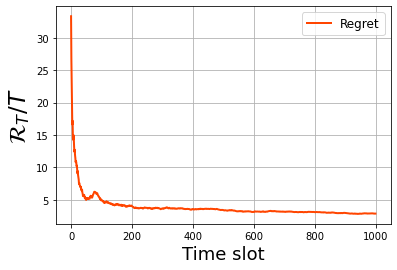

In [8]:
# run BSvBS algorithm
bsvbs_algorithm = BSvBSAlgorithm(N, T, S, delta, config_dict, cd_arr, reward_min, reward_max)
reward_chosen, cd_arr = bsvbs_algorithm.run()


# reward calculation for best/ideal configuration
best_benchmark = BestBenchmark(T, S, delta, config_dict, cd_arr, reward_min, reward_max)
reward_all = best_benchmark.calculate_best_benchmark()
G_max = np.array([np.max(reward_all[:, t]) for t in range(T)])


# compute static expected regret
E_BSvBS = np.mean(reward_chosen, 0)
E_G_BSvBS = np.cumsum(E_BSvBS)
static_expected_regret = G_max - E_G_BSvBS


# plot the static expected regret
t = np.arange(T)
plt.figure(1)
plt.xlabel('Time slot', fontsize=18)
plt.ylabel(r'$\mathcal{R}_T/T$', fontsize=23)
plt.plot(static_expected_regret[1:] / t[1:], linewidth=2, label='Regret', color='orangered')
plt.grid()
plt.legend(fontsize=12)
plt.show()

In [9]:
np.sum(E_BSvBS)

601.8242653684027